### Import Packages

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
import optuna
import numpy as np
from optuna.samplers import TPESampler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Load data.

In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [4]:
train_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
test_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

### Separate target and features from training datasets.

In [6]:
y_train = train_data['SalePrice']
X_train = train_data.drop('SalePrice', axis=1)

In [7]:
# List of categorical and numerical features.
categorical_features = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
                        'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
                        'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
                        'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
                        'Foundation', 'BsmtQual', 'BsmtCond']
numerical_features = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
                      'YearRemodAdd', 'MasVnrArea']


### Feature Exploration

In [8]:
# Check missing values in each column
missing_values = X_train.isnull().sum()
missing_values[missing_values > 0]

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

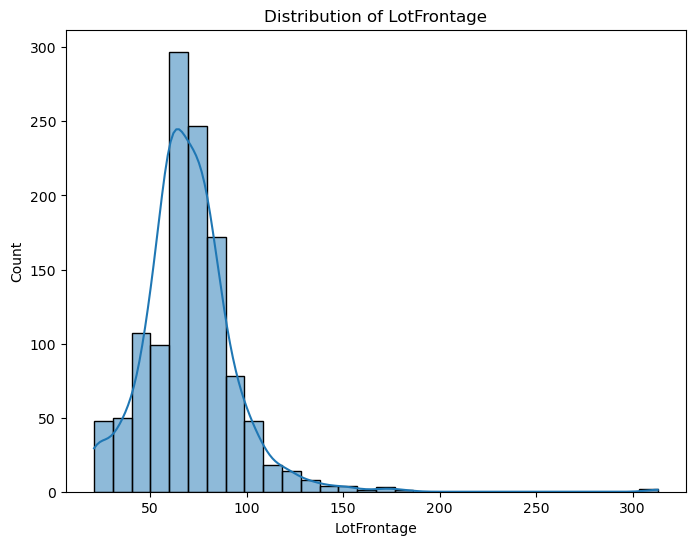

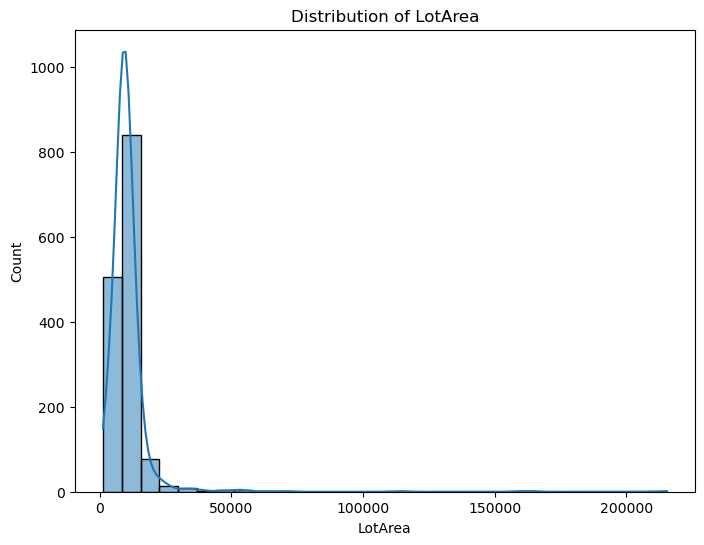

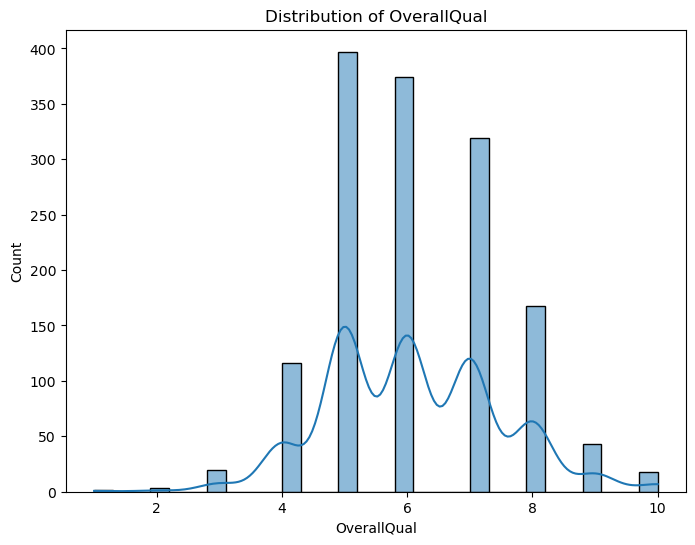

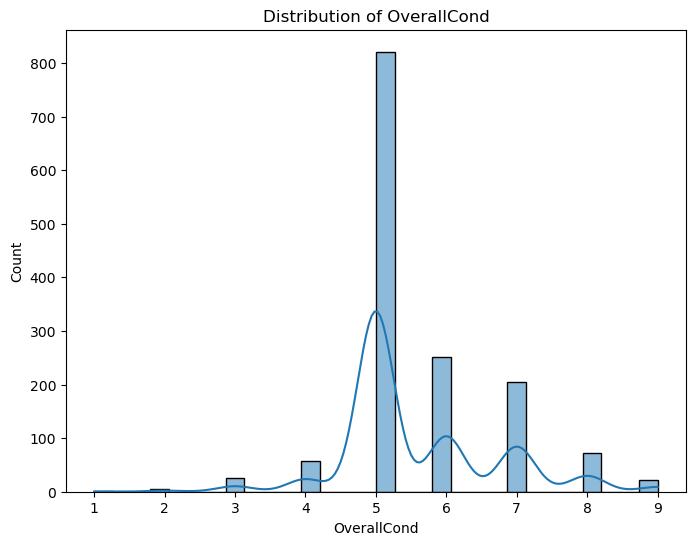

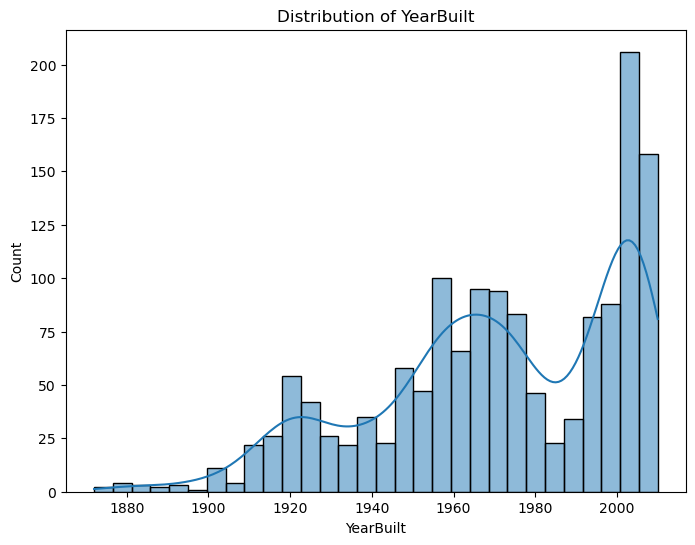

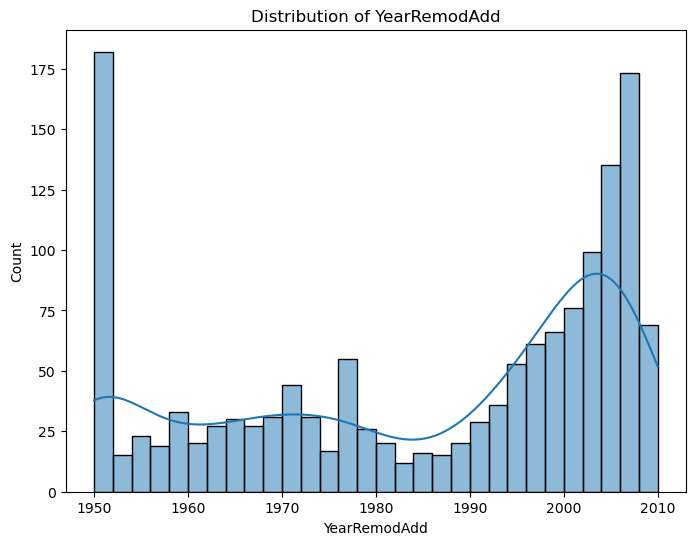

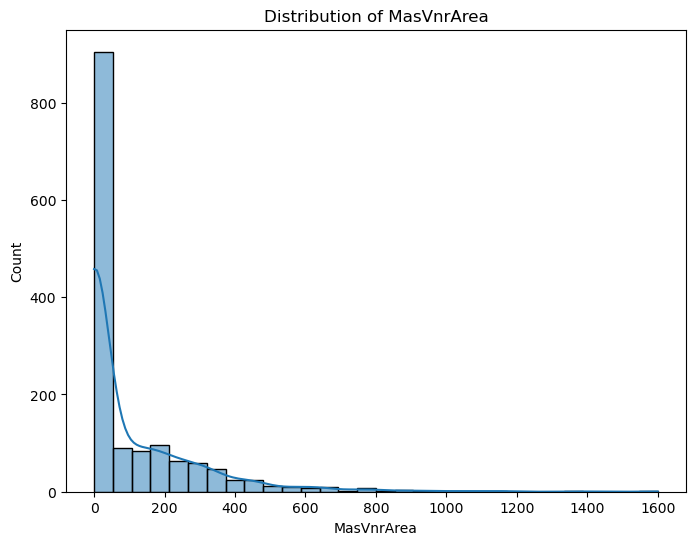

In [12]:
# Visualize the distribution of each numerical feature
for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(X_train[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.show()

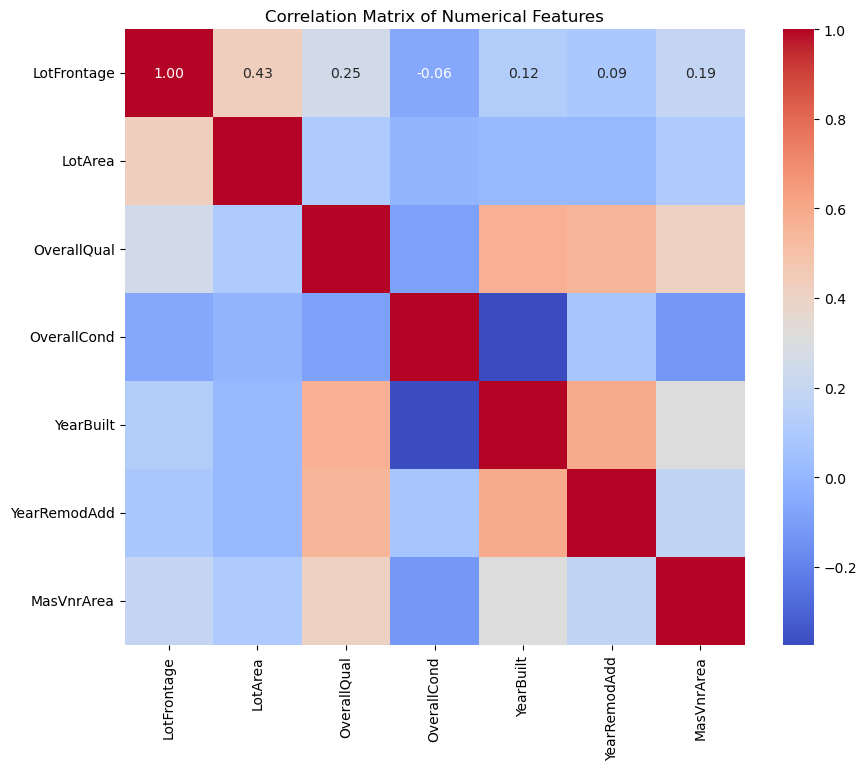

In [14]:
# Visualize the correlation matrix of numerical features
correlation_matrix = X_train[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

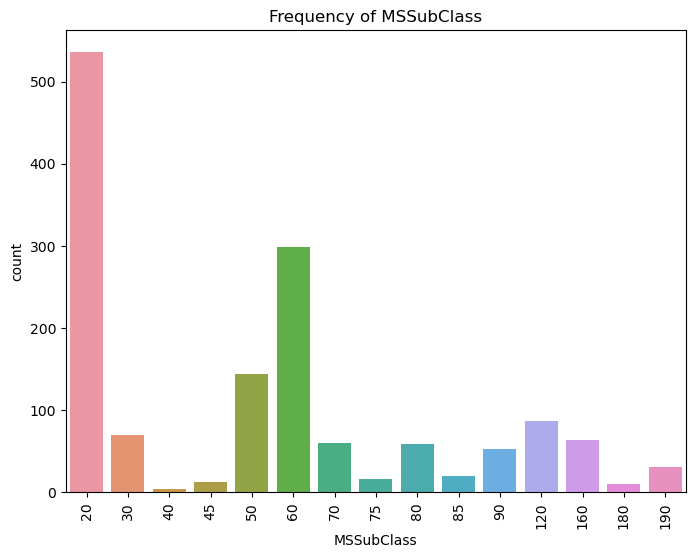

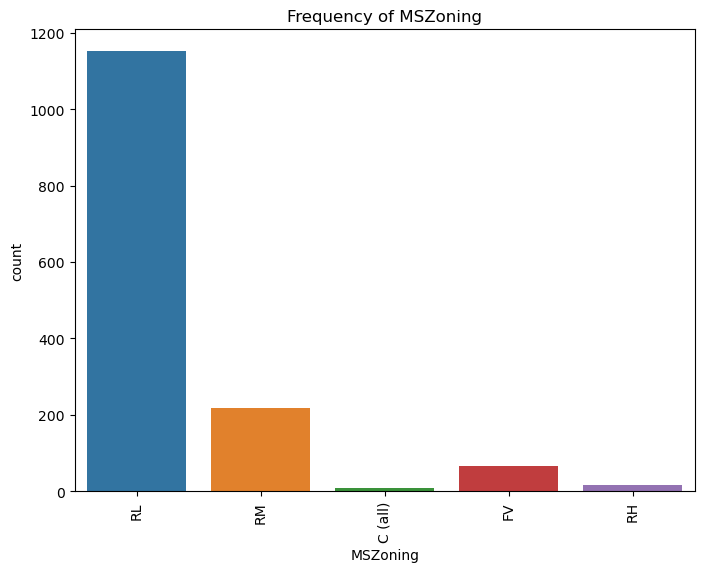

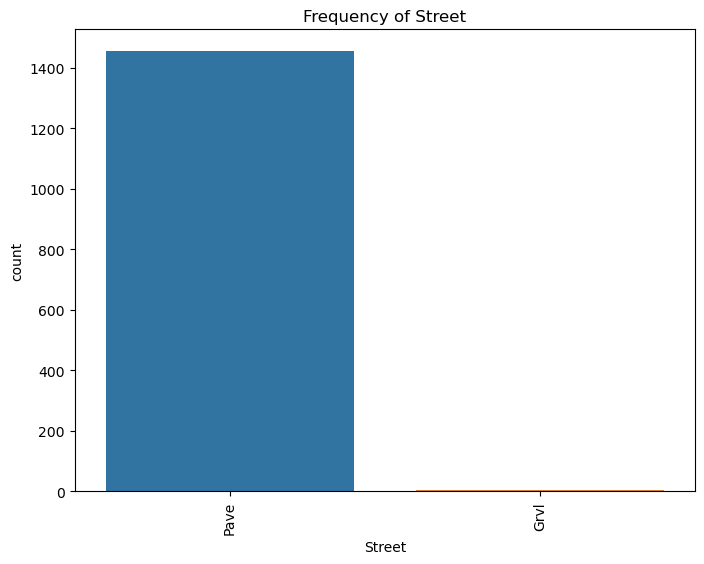

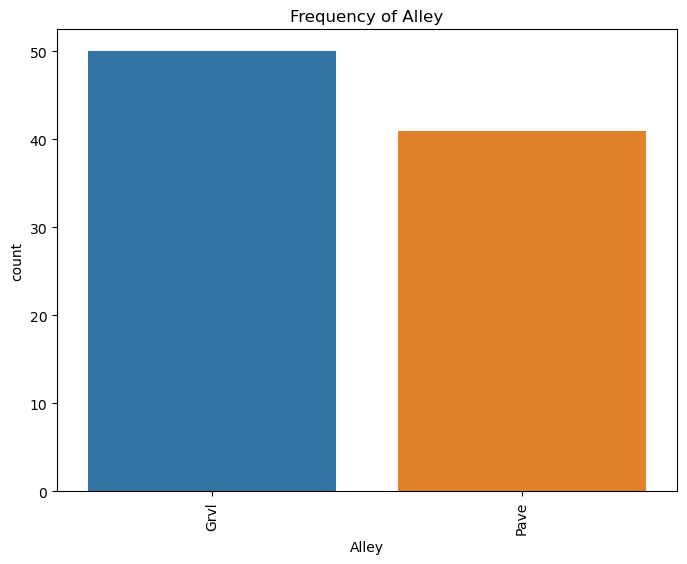

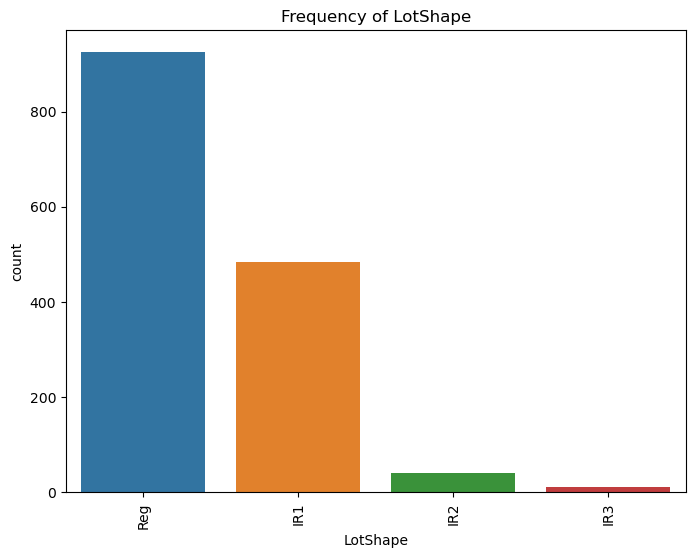

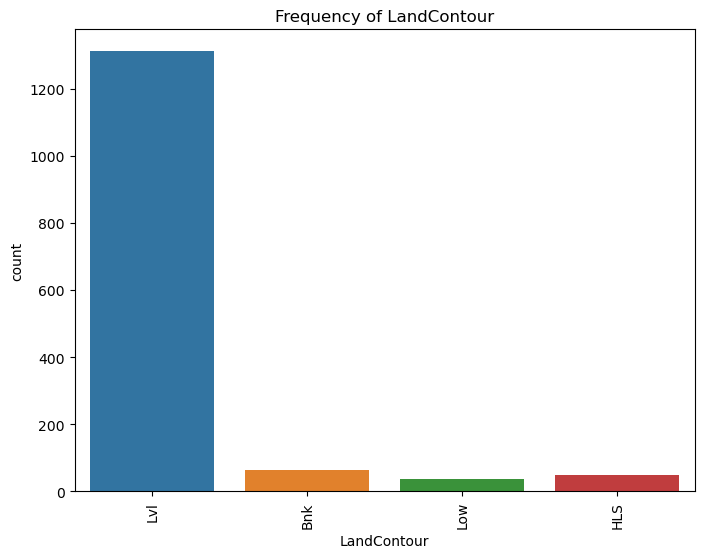

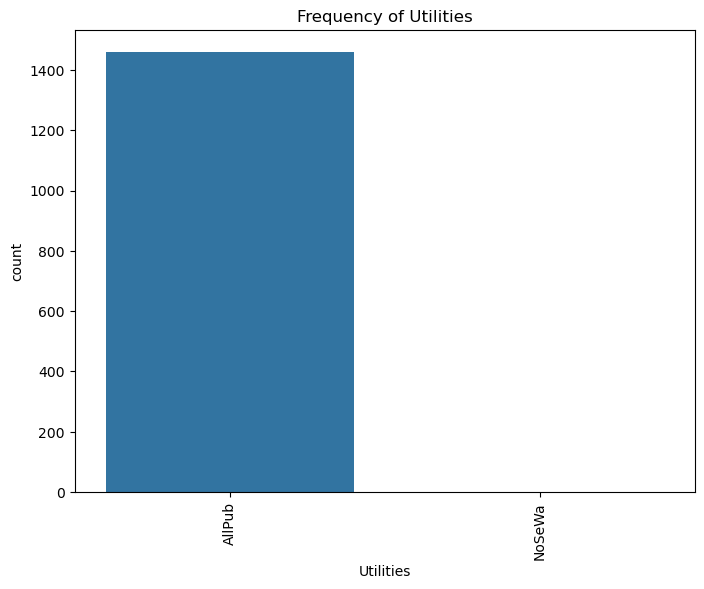

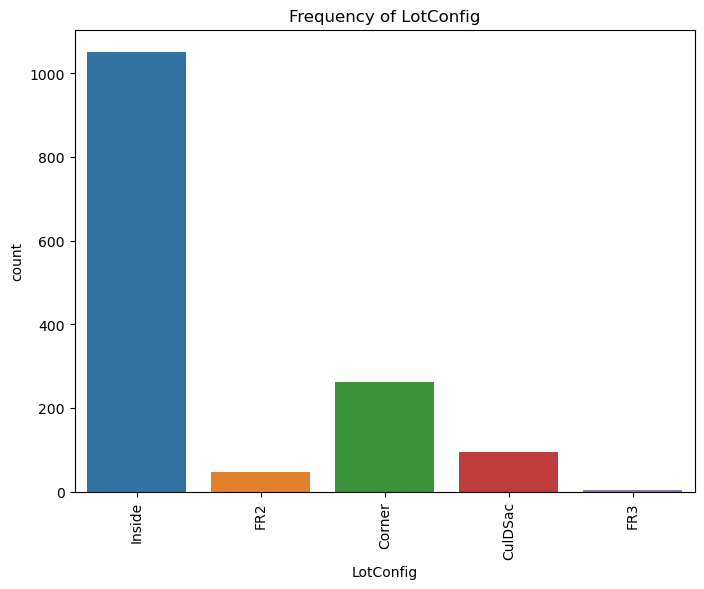

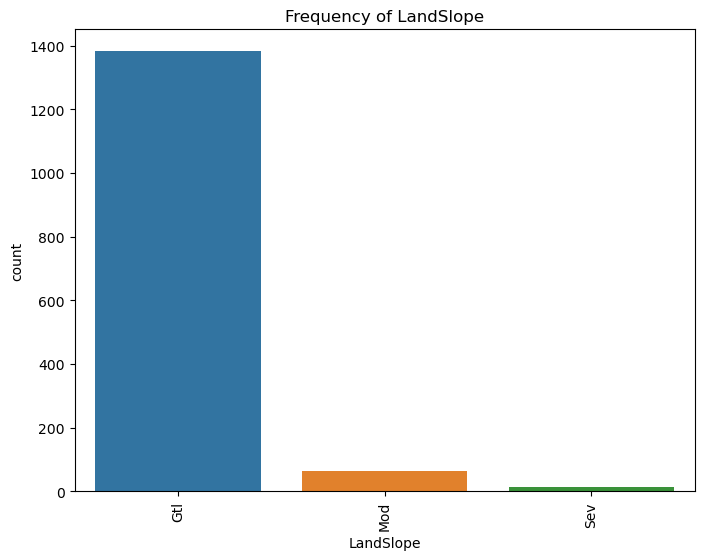

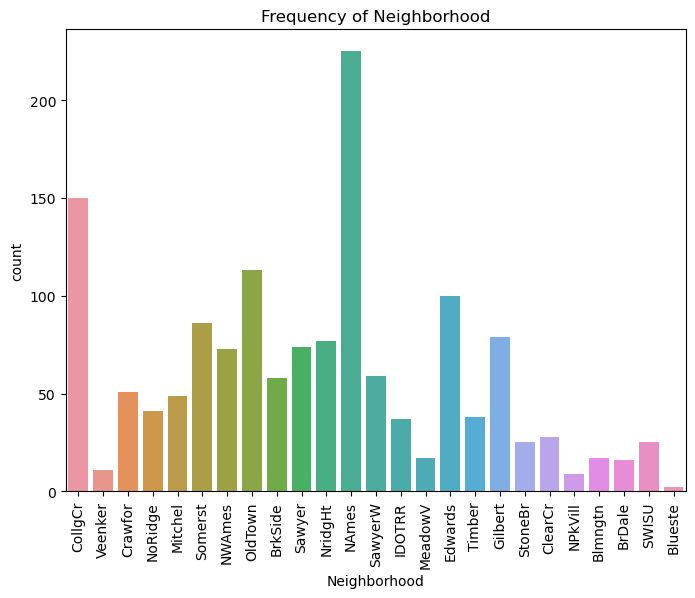

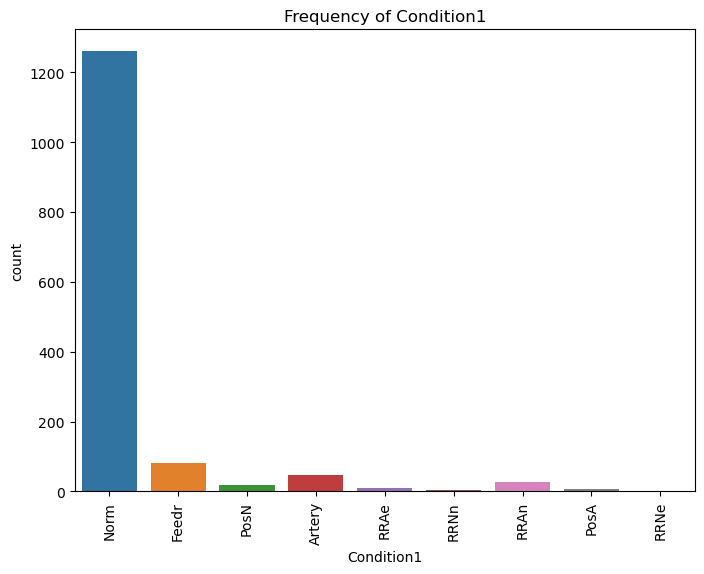

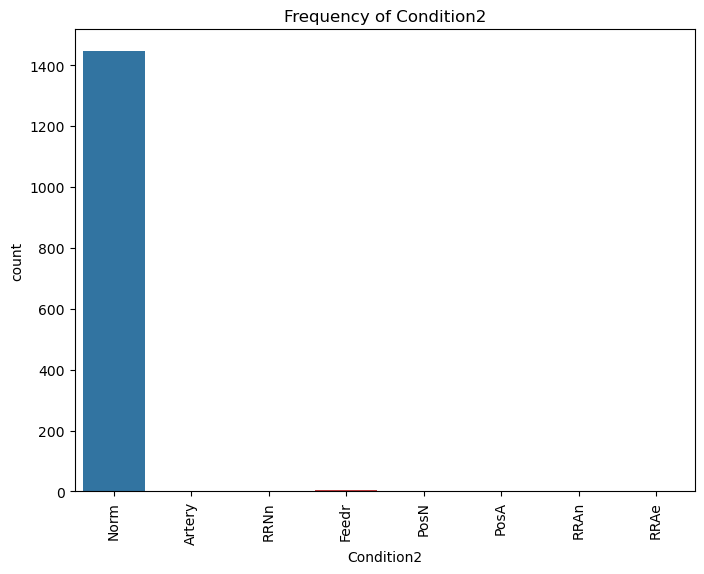

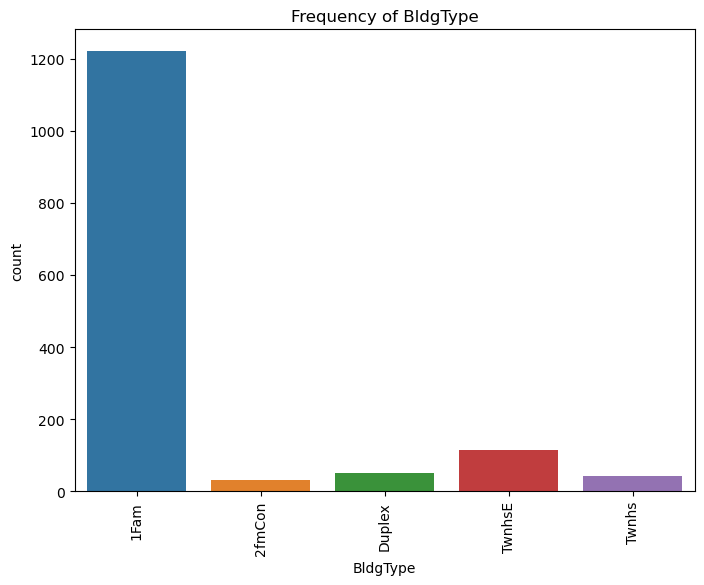

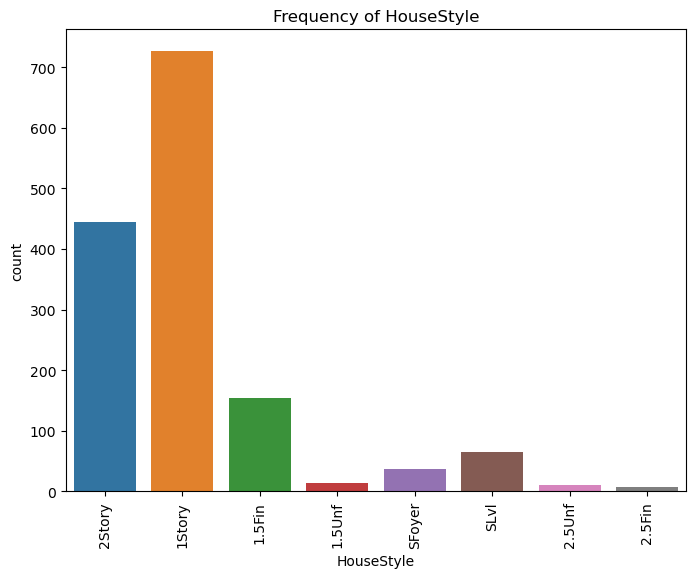

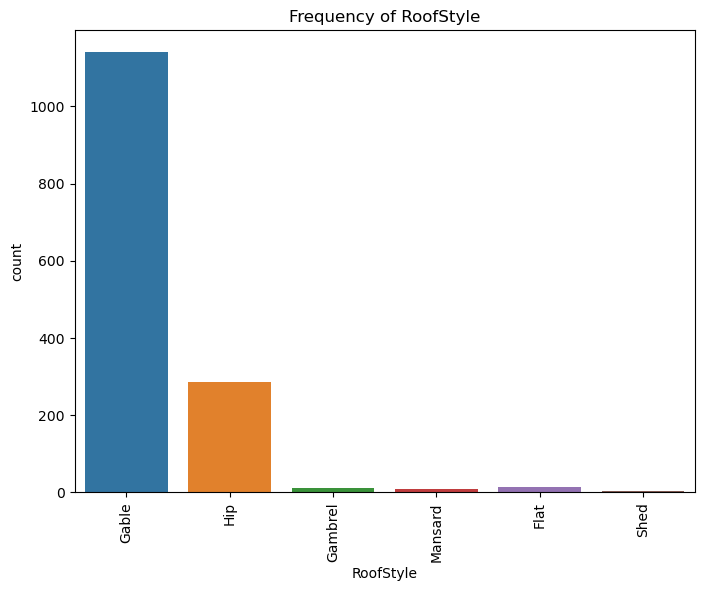

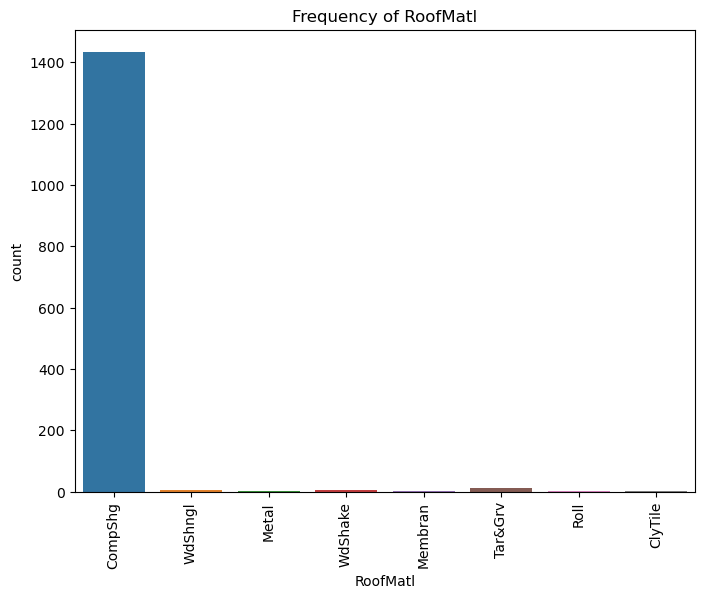

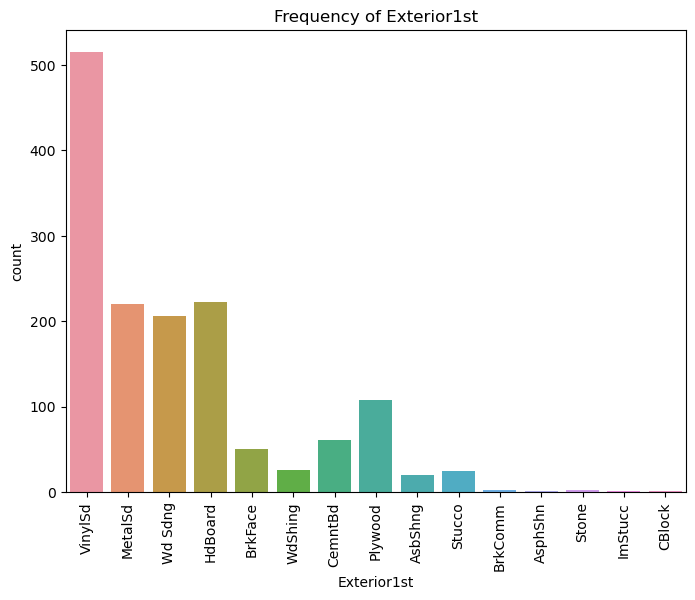

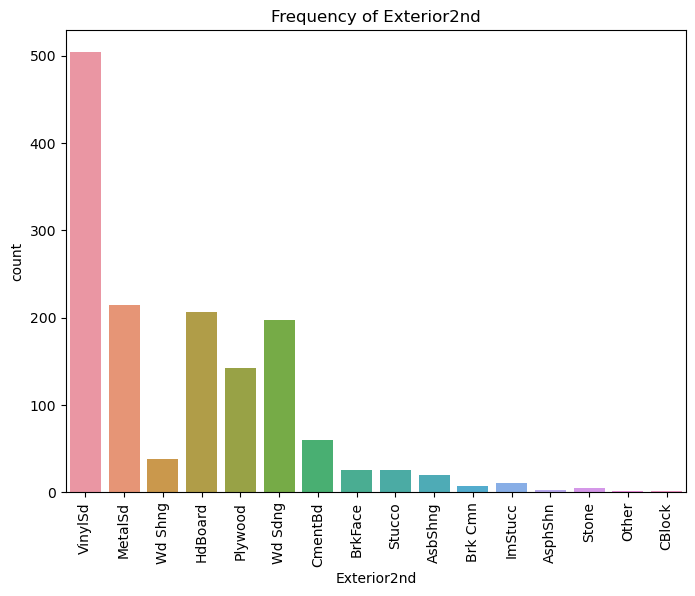

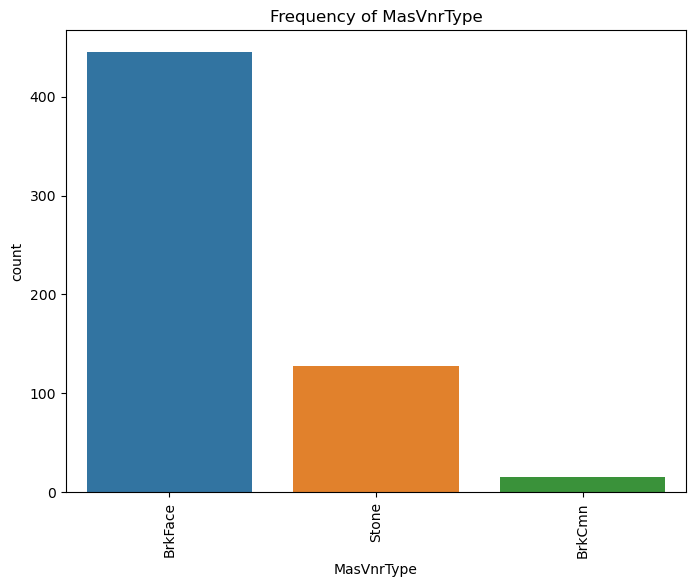

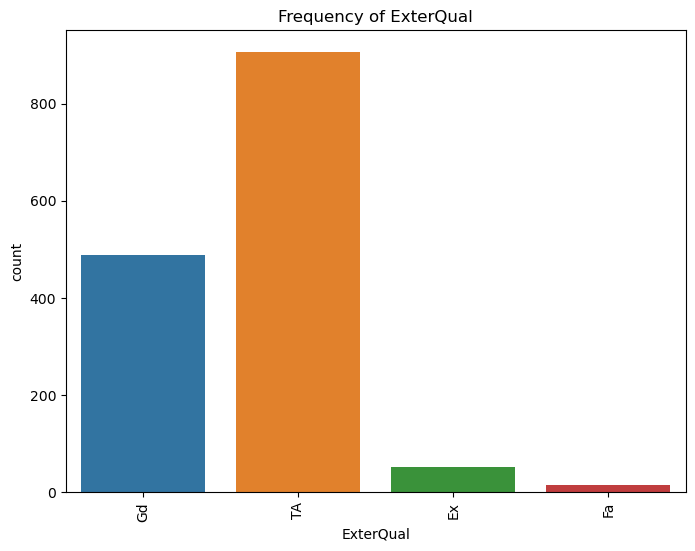

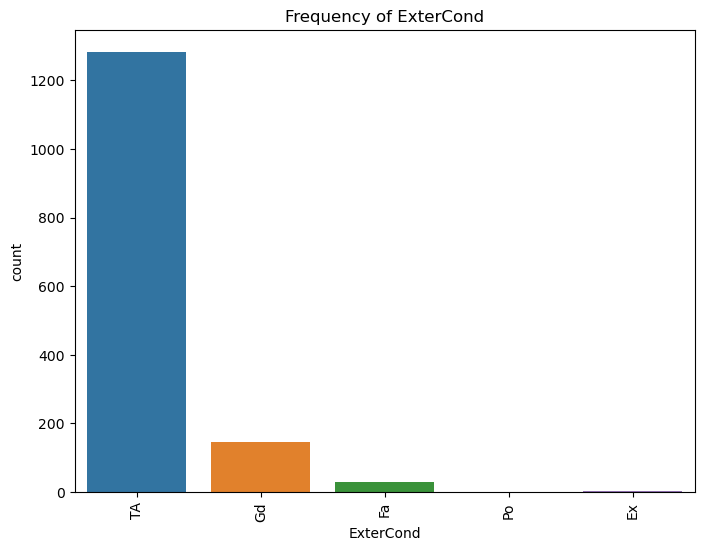

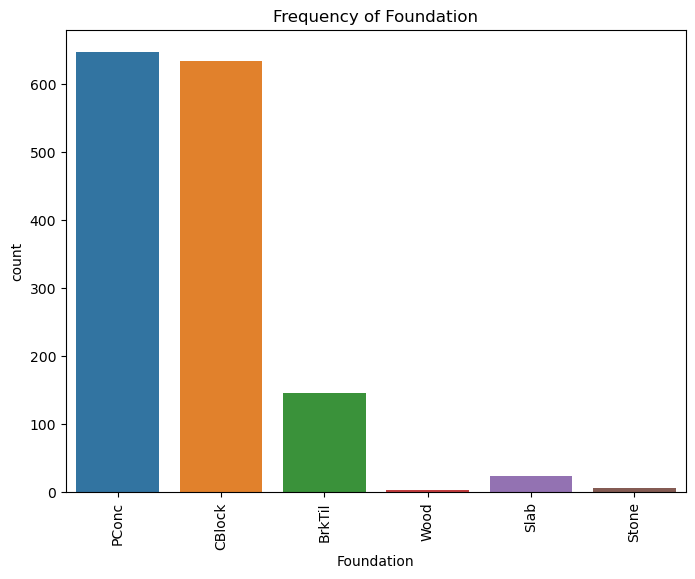

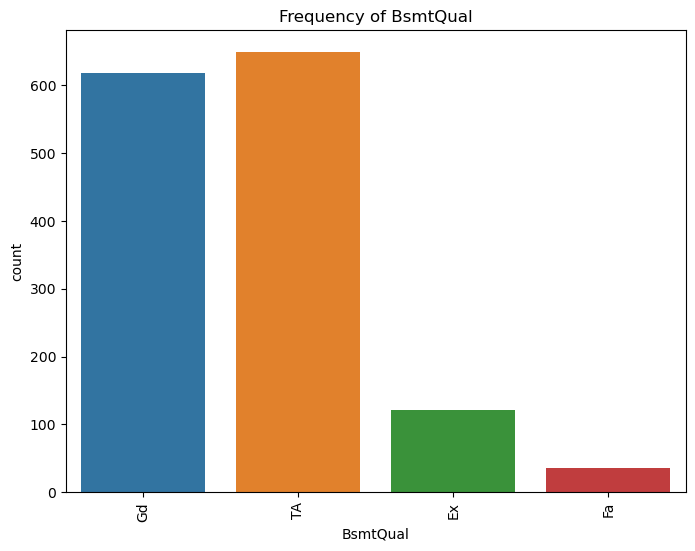

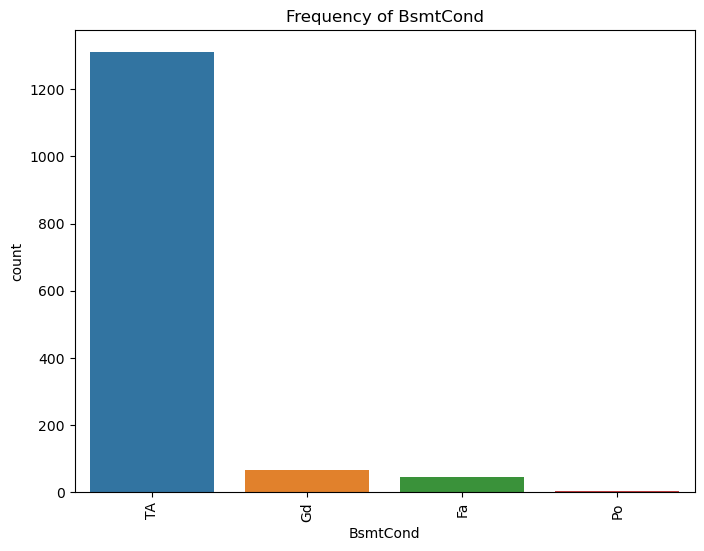

In [15]:
# Visualize the distribution of each categorical feature
for feature in categorical_features:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=X_train[feature])
    plt.title(f'Frequency of {feature}')
    plt.xticks(rotation=90)
    plt.show()

### Create Preprocessor

In [16]:
# Preprocessing missing values for numerical and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing numerical values with the mean
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing categorical values with the most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))  # Ensure dense output
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [17]:
X_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


### MAPE evaluates the relative error/differences between the predicted and actual values, making it appropriate when comparing predictions across house prices in different ranges.

In [18]:
def mape_scorer(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

In [21]:
# Objective function for Optuna
def objective(trial):
    model_choice = trial.suggest_categorical('model', [
        'ElasticNet', 
        'RandomForest', 
        'HistGradientBoosting', 
    ])
    
    if model_choice == 'ElasticNet':
        regressor = ElasticNet(
            alpha=trial.suggest_loguniform('alpha', 1e-3, 1e2),
            l1_ratio=trial.suggest_uniform('l1_ratio', 0, 1),  # L1/L2 regularization mix
            max_iter=trial.suggest_int('max_iter', 1000, 5000)
        )
    elif model_choice == 'RandomForest':
        regressor = RandomForestRegressor(
            n_estimators=trial.suggest_int('n_estimators', 100, 500),
            max_depth=trial.suggest_int('max_depth', 3, 20),
            min_samples_split=trial.suggest_int('min_samples_split', 2, 10),
            min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 4),
            bootstrap=trial.suggest_categorical('bootstrap', [True, False]),
            random_state=46
        )
    elif model_choice == 'HistGradientBoosting':
        regressor = HistGradientBoostingRegressor(
            max_iter=trial.suggest_int('max_iter', 100, 500),
            max_depth=trial.suggest_int('max_depth', 3, 20),
            learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
            min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 5),
            max_bins=trial.suggest_int('max_bins', 2, 255)
        )

    # Create a pipeline that applies preprocessing and then the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),  # Ensure preprocessor is defined
        ('regressor', regressor)
    ])
    
    # Perform cross-validation with MAPE
    kfold = KFold(n_splits=10, shuffle=True, random_state=46)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring=make_scorer(mape_scorer))
    
    # Return the mean of the cross-validation MAPE scores
    return np.mean(cv_scores)

In [22]:
# Run Bayesian Optimization with Optuna
study = optuna.create_study(direction='minimize', study_name='house_price_optimization')
study.optimize(objective, n_trials=100, n_jobs=-1)  # Parallelize optimization by using all cores

# Output the best model and parameters
print(f"Best model: {study.best_trial.params['model']}")
print(f"Best parameters: {study.best_trial.params}")
print(f"Best CV MAPE: {study.best_value}")

[I 2024-11-21 14:31:27,321] A new study created in memory with name: house_price_optimization
[I 2024-11-21 14:31:28,736] Trial 0 finished with value: 0.2808872253078923 and parameters: {'model': 'ElasticNet', 'alpha': 28.56567769346217, 'l1_ratio': 0.7227580190339724, 'max_iter': 3034}. Best is trial 0 with value: 0.2808872253078923.
[I 2024-11-21 14:31:33,517] Trial 6 finished with value: 0.15304079766706197 and parameters: {'model': 'RandomForest', 'n_estimators': 126, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 6 with value: 0.15304079766706197.
[I 2024-11-21 14:31:35,209] Trial 4 finished with value: 0.13465732376998102 and parameters: {'model': 'RandomForest', 'n_estimators': 115, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 4 with value: 0.13465732376998102.
[I 2024-11-21 14:31:42,907] Trial 10 finished with value: 0.13848407402042726 and parameters: {'model': 'ElasticNet', '

Best model: HistGradientBoosting
Best parameters: {'model': 'HistGradientBoosting', 'max_iter': 222, 'max_depth': 9, 'learning_rate': 0.051555539173376144, 'min_samples_leaf': 5, 'max_bins': 121}
Best CV MAPE: 0.12418261069943548


### Apply preprocessing to test data features and make final predictions.

In [27]:
final_model = HistGradientBoostingRegressor(
            max_iter=222,
            max_depth=9,
            learning_rate=0.051555539173376144,
            min_samples_leaf=5,
            max_bins=121
        )

final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('regressor', final_model)
])

final_pipeline.fit(X_train, y_train)
test_predictions = final_pipeline.predict(test_data)

In [28]:
# Save predictions to CSV
output = pd.DataFrame({'Id': test_data['Id'], 'SalePrice': test_predictions})
print(output.head(10))
#output.to_csv('test_predictions.csv', index=False)

     Id      SalePrice
0  1461  135957.610482
1  1462  166305.294682
2  1463  156817.866178
3  1464  197217.288125
4  1465  188586.230639
5  1466  171624.459380
6  1467  166013.226560
7  1468  180838.193085
8  1469  174700.144635
9  1470  119617.917622


In [29]:
output.to_csv('test_predictions.csv', index=False)